In [ ]:
# General imports
import pandas as pd

# Grid search
from library.genetic_algorithms.grid_search_parallelized import grid_search_par
from library.genetic_algorithms.mutation import swap_mutation, inversion_mutation, heuristic_mutation, misfit_mutation
from library.genetic_algorithms.crossover import cycle_crossover, one_point_crossover, uniform_crossover, geometric_crossover
from library.genetic_algorithms.selection import fitness_proportionate_selection, ranking_selection, tournament_selection

# Plotting
from matplotlib import pyplot as plt
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare
import plotly.graph_objects as go
from IPython.display import display

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare
import plotly.graph_objects as go
from IPython.display import display


In [3]:
seating_data= pd.read_csv("seating_data.csv", index_col=0)

In [3]:
relationships_mtx=seating_data.to_numpy()

In [4]:
relationships_mtx

array([[   0, 5000,    0, ...,    0,    0,    0],
       [5000,    0,  700, ...,    0,    0,    0],
       [   0,  700,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,  700,  700],
       [   0,    0,    0, ...,  700,    0,  900],
       [   0,    0,    0, ...,  700,  900,    0]], shape=(64, 64))

# Experiment with different mutation, crossover and selection methods

## Fixed hyperparameters:
- population size = 100
- max generations = 100
- crossover probability = 0.9
- mutation probability = 0.1
- when selection method is tournment: tournment size = 3

In [5]:
# Testing grid search code 

results = grid_search_par(
    relations_mtx=relationships_mtx,
    mutation_functions=[swap_mutation, inversion_mutation, heuristic_mutation, misfit_mutation],
    crossover_functions=[cycle_crossover, one_point_crossover, uniform_crossover, geometric_crossover],
    selection_functions=[fitness_proportionate_selection, ranking_selection, tournament_selection],
    elitism=[0,1]
)

results #results is empty, therefore nothing is printed

[{'mutation': 'heuristic_mutation',
  'crossover': 'geometric_crossover',
  'selection': 'tournament_selection',
  'elitism': 1,
  'last_gen_avg_fitness': np.float64(78346.66666666667),
  'solution_highest_fitness': <library.SA_problem.seating_arrangement.SASolution at 0x20341fb3440>,
  'execution_time': 21.119258880615234}]

Each combination (w/ 30 runs) takes around 6 min.
- 48 combinations: 4.8 h.

In [6]:
results_table1 = pd.DataFrame(results).style \
    .format(precision=3) \
    .set_properties(**{"text-align": "center"}) \
    .set_table_styles([{
        "selector": "th",
        "props": [("text-align", "center")]
    }])

results_table1

# Experiment with different nr of elits for best mutation, crossover and selection method

In [7]:
results = grid_search_par(
    relations_mtx=relationships_mtx,
    mutation_functions=[], # add best mutation
    crossover_functions=[], # add best crossover
    selection_functions=[], # add best selection
    elitism=[0, 5]
)

Each combination (w/ 30 runs) takes around 6 min.
- 2 combinations: 12 min.

In [8]:
results_table2 = pd.DataFrame(results).style \
    .format(precision=3) \
    .set_properties(**{"text-align": "center"}) \
    .set_table_styles([{
        "selector": "th",
        "props": [("text-align", "center")]
    }])

results_table2

# Experimental Analysis

In [4]:
avg_fitness_per_gen= pd.read_csv("avg_fitness_per_generation.csv")
fitness_per_run= pd.read_csv("fitness_per_run.csv")

In [8]:
print(avg_fitness_per_gen.shape)
print(fitness_per_run.shape)

(9600, 6)
(288000, 7)


## Tracking Performance Across Generations for Different Operators

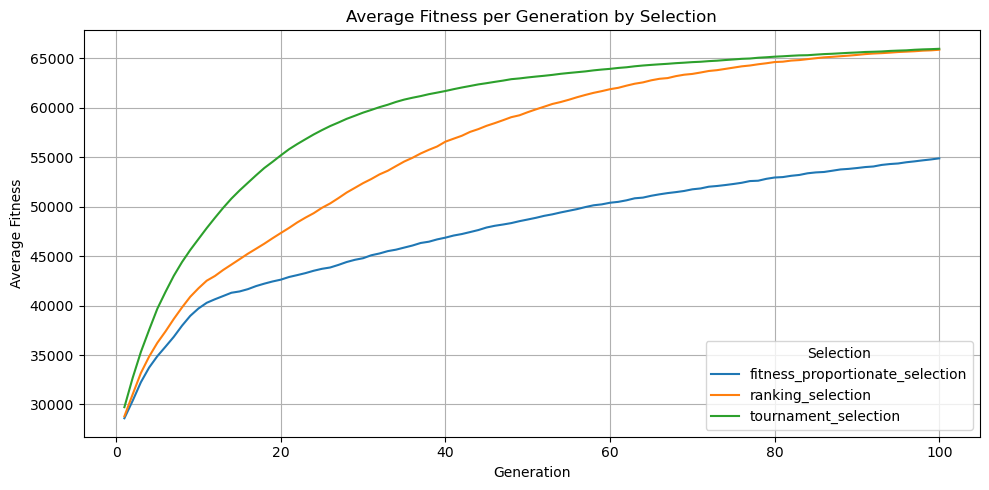

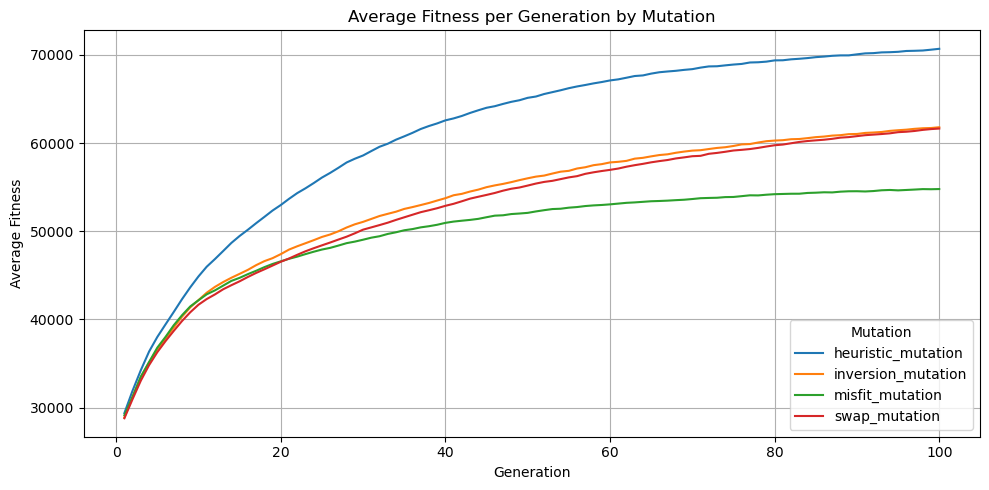

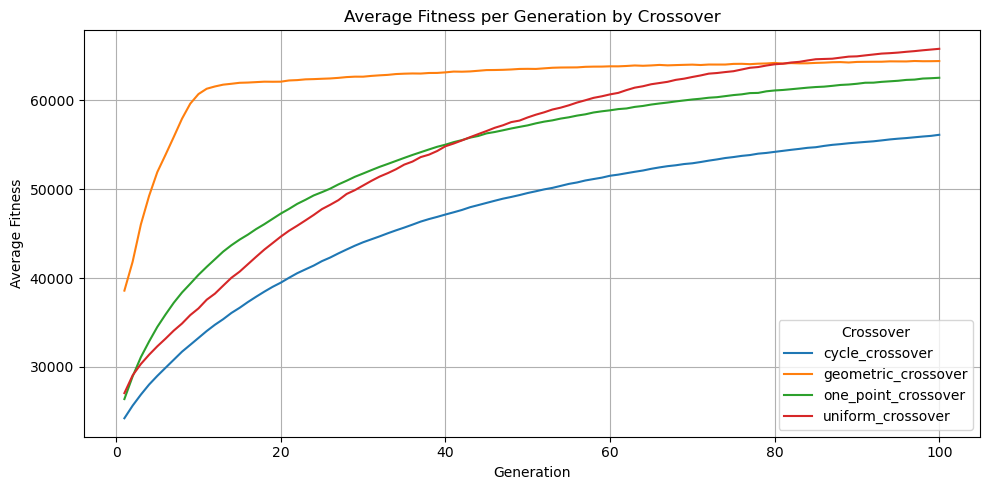

In [20]:
def plot_avg_fitness_by_operator(df, operator_name):
    grouped = df.groupby([operator_name, "generation"])["avg_fitness"].mean().reset_index()

    plt.figure(figsize=(10, 5))
    for op in grouped[operator_name].unique():
        subset = grouped[grouped[operator_name] == op]
        plt.plot(subset["generation"], subset["avg_fitness"], label=op)

    plt.title(f"Average Fitness per Generation by {operator_name.capitalize()}")
    plt.xlabel("Generation")
    plt.ylabel("Average Fitness")
    plt.legend(title=operator_name.capitalize(), loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot para cada operador
for operator in ["selection", "mutation", "crossover"]:
    plot_avg_fitness_by_operator(avg_fitness_per_gen, operator)

## Plot average fitness per gen 

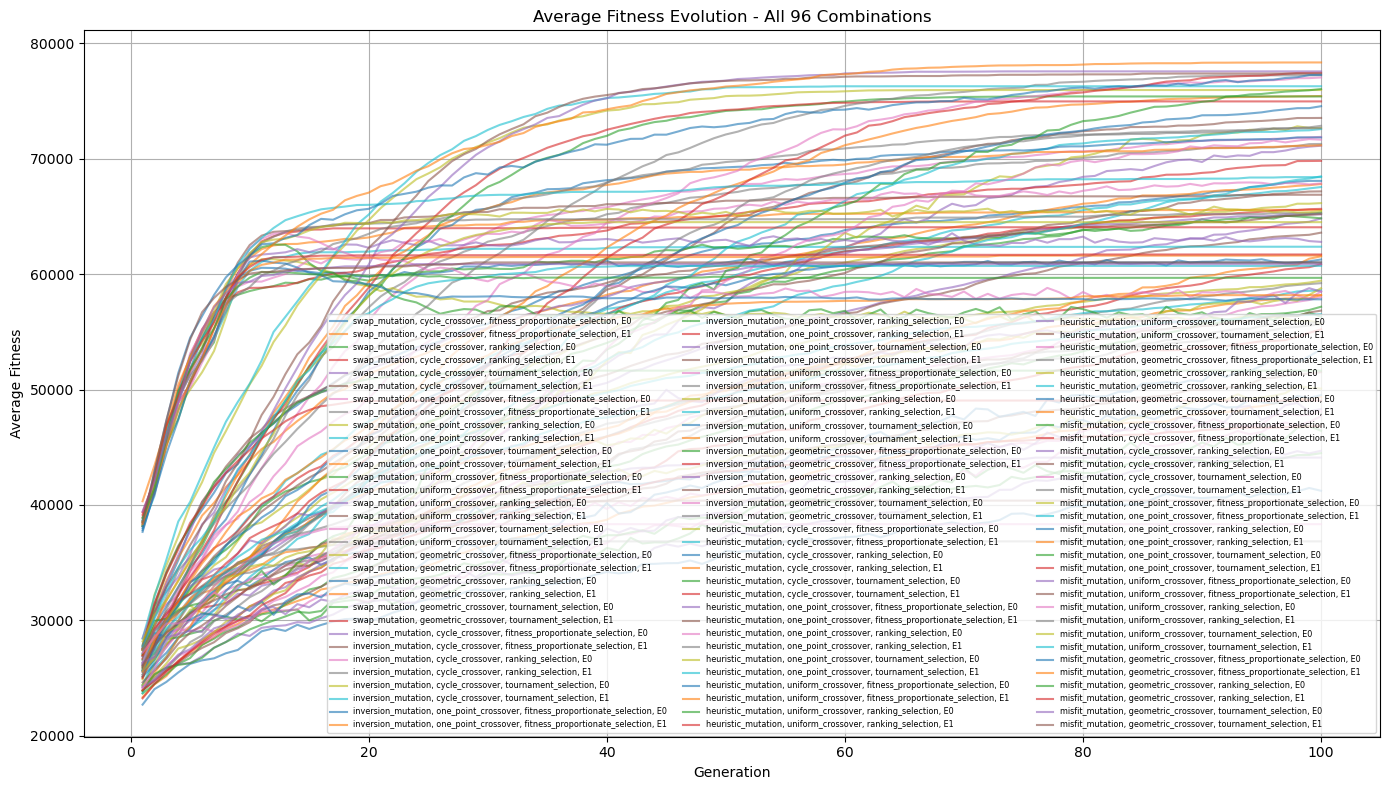

In [ ]:
avg_fitness_per_gen["combination"] = avg_fitness_per_gen.apply(
    lambda row: f"{row["mutation"]}, {row["crossover"]}, {row["selection"]}, E{row["elitism"]}",
    axis=1
)

# Plot all 48 curves
plt.figure(figsize=(14, 8))

for combo in avg_fitness_per_gen["combination"].unique():
    subset = avg_fitness_per_gen[avg_fitness_per_gen["combination"] == combo]
    plt.plot(subset["generation"], subset["avg_fitness"], label=combo, alpha=0.6)

plt.xlabel("Generation")
plt.ylabel("Average Fitness")
plt.title("Average Fitness Evolution - All 96 Combinations")
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize="xx-small", ncol=3, loc="lower right")
plt.show()

Due to the high number of combinations being evaluated, we will focus on plotting only the top 5 combinations. These top 5 are selected based on achieving the highest average fitness values in the final generation. By doing so, we can clearly visualize and compare the best-performing configurations in terms of fitness evolution over the generations.

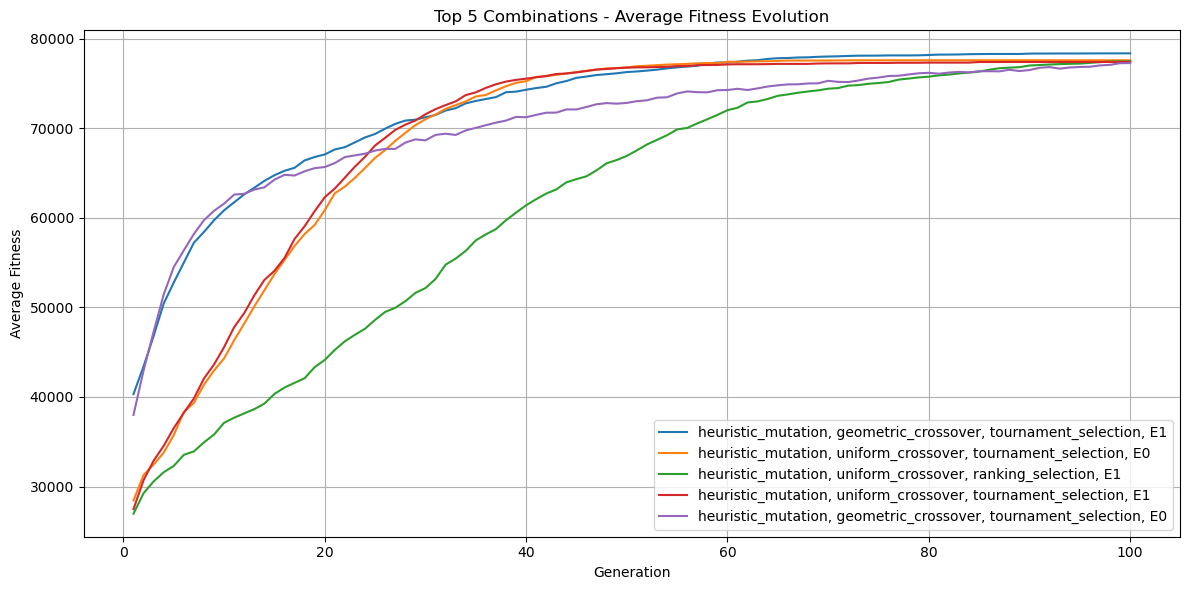

In [10]:
# Filter the last generation
last_gen = avg_fitness_per_gen[avg_fitness_per_gen["generation"] == avg_fitness_per_gen["generation"].max()]

# Select top 5 combinations by average fitness in the last generation
top5_combinations = last_gen.sort_values(by="avg_fitness", ascending=False)["combination"].head(5).unique()

# Filter data for these top 5 combinations
df_top5 = avg_fitness_per_gen[avg_fitness_per_gen["combination"].isin(top5_combinations)]

# Plot the curves
plt.figure(figsize=(12, 6))
for combo in top5_combinations:
    subset = df_top5[df_top5["combination"] == combo]
    plt.plot(subset["generation"], subset["avg_fitness"], label=combo)

plt.xlabel("Generation")
plt.ylabel("Average Fitness")
plt.title("Top 5 Combinations - Average Fitness Evolution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


We are going to add the standard desviation to our plot

In [ ]:
stats = fitness_per_run.groupby(
    ["mutation", "crossover", "selection", "elitism", "generation"]
)["fitness"].agg(["mean", "std"]).reset_index()


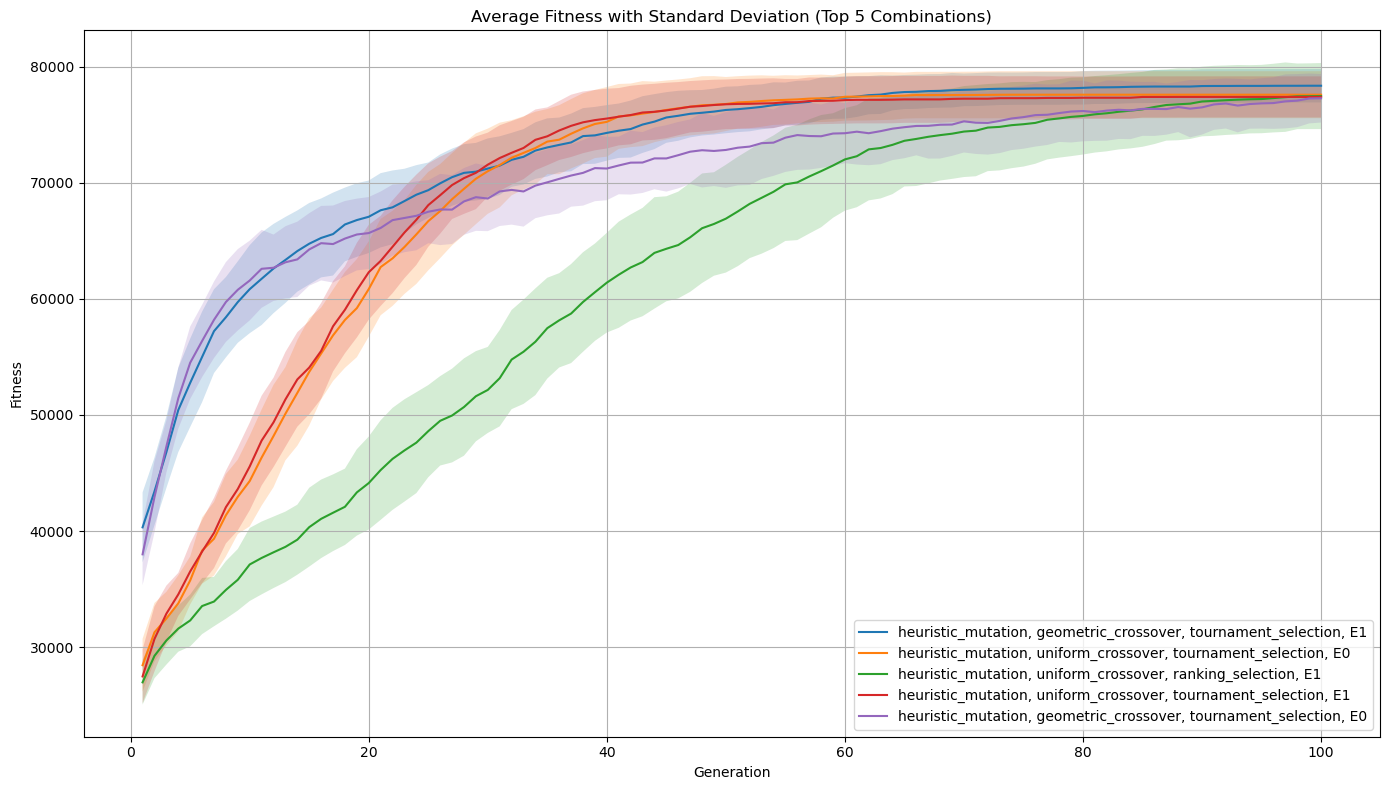

In [21]:
stats["combination"] = stats.apply(
    lambda row: f"{row["mutation"]}, {row["crossover"]}, {row["selection"]}, E{row["elitism"]}",
    axis=1
)

stats.rename(columns={"mean": "avg_fitness", "std": "std_fitness"}, inplace=True)

stats_top5 = stats[stats["combination"].isin(top5_combinations)]


plt.figure(figsize=(14, 8))

for combo in top5_combinations:
    subset = stats_top5[stats_top5["combination"] == combo]
    
    plt.plot(subset["generation"], subset["avg_fitness"], label=combo)
    
    # Sombrear o intervalo avg ± std
    plt.fill_between(
        subset["generation"],
        subset["avg_fitness"] - subset["std_fitness"],
        subset["avg_fitness"] + subset["std_fitness"],
        alpha=0.2
    )

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Average Fitness with Standard Deviation (Top 5 Combinations)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# Performs statistical tests

In [5]:
avg_fitness_per_gen['configuration'] = avg_fitness_per_gen[['mutation', 'crossover', 'selection', 'elitism']].astype(str).agg('-'.join, axis=1)

# Group avg_fitness values ​​by configuration
grouped = avg_fitness_per_gen.groupby('configuration')['avg_fitness'].apply(list)

score_df = pd.DataFrame(grouped.tolist(), index=grouped.index).T
score_df = score_df.dropna(axis=1)

# Global significance test 
stat, p = friedmanchisquare(*[score_df[col] for col in score_df.columns])
print(f"Friedman test statistic: {stat:.4f}, p-value: {p:.4f}")

alpha_sig = 0.05
if p < alpha_sig:
    print("There are statistically significant differences between the configurations.")

    # Pair-wise test
    nemenyi = sp.posthoc_nemenyi_friedman(score_df.to_numpy())
    display(
        nemenyi.style
            .set_caption("Post-hoc Nemenyi test")
            .format(precision=4)
            .map(lambda v: 'background-color: lightcoral' if v < alpha_sig else '')
            .set_properties(**{'text-align': 'center'})
    )
else:
    print("No statistically significant differences were found between the configurations.")

Friedman test statistic: 7971.9967, p-value: 0.0000
There are statistically significant differences between the configurations.


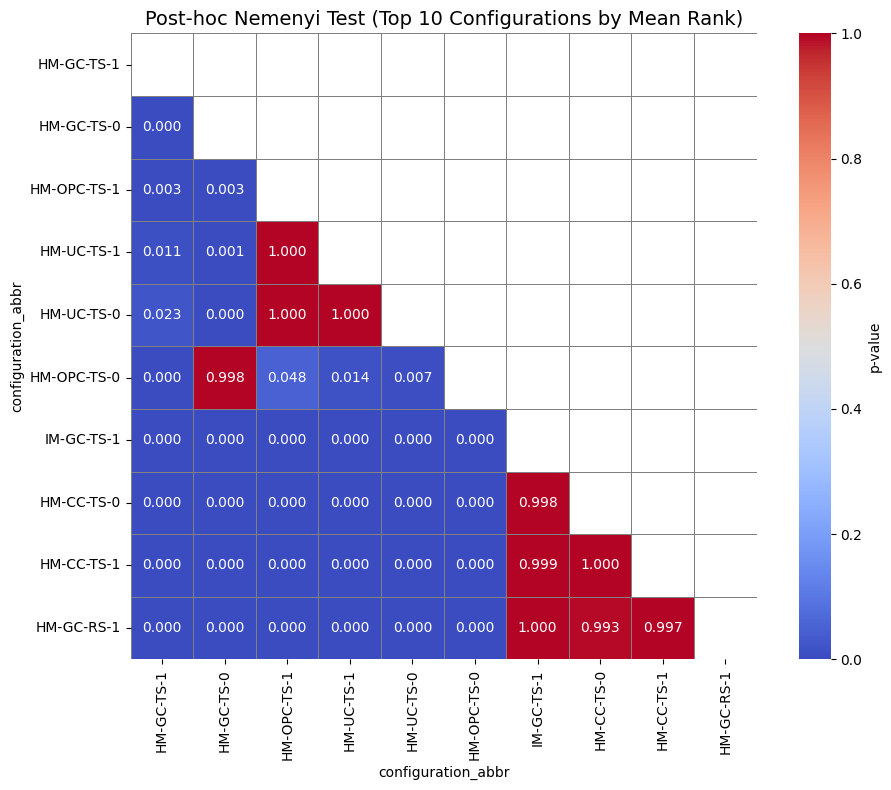

In [ ]:
# post-hoc Nemenyi test for the 10 configurations with the best average fitness
mean_ranks = score_df.rank(axis=1, method='average', ascending=False).mean().sort_values()

top_n = 10
top_configs = mean_ranks.head(top_n).index

top_score_df = score_df[top_configs]
nemenyi_top = sp.posthoc_nemenyi_friedman(top_score_df.to_numpy())
nemenyi_top.index = nemenyi_top.columns = top_score_df.columns

plt.figure(figsize=(10, 8))
sns.heatmap(
    nemenyi_top,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    cbar_kws={"label": "p-value"},
    linewidths=0.5,
    linecolor='gray',
    mask=np.triu(np.ones_like(nemenyi_top, dtype=bool)),
    square=True
)
plt.title(f"Post-hoc Nemenyi Test (Top {top_n} Configurations by Mean Rank)", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# abreviations for the operators (for better visualization)
abbr = {
    'heuristic_mutation': 'HM',
    'swap_mutation': 'SM',
    'inversion_mutation': 'IM',
    'misfit_mutation': 'MM',
    'geometric_crossover': 'GC',
    'uniform_crossover': 'UC',
    'one_point_crossover': 'OPC',
    'cycle_crossover': 'CC',
    'tournament_selection': 'TS',
    'ranking_selection': 'RS',
    'fitness_proportionate_selection': 'FPS',
}

def abbreviate_config(config):
    parts = config.split('-')
    return '-'.join(abbr.get(part, part) for part in parts)

In [39]:
df_long = score_df.melt(var_name="Configuration", value_name="Fitness")

df_long['Selection'] = df_long['Configuration'].apply(lambda x: x.split('-')[2])

df_long['Config_Abbr'] = df_long['Configuration'].apply(abbreviate_config)

stats_df = df_long.groupby("Configuration")["Fitness"].agg(
    min_score="min",
    q1_score=lambda x: np.percentile(x, 25),
    median_score="median",
    q3_score=lambda x: np.percentile(x, 75),
    max_score="max"
).reset_index()

def make_hover(config):
    stats = stats_df[stats_df['Configuration'] == config].iloc[0]
    return (
        f"Max: {stats.max_score:.2f}<br>"
        f"Q3: {stats.q3_score:.2f}<br>"
        f"Median: {stats.median_score:.2f}<br>"
        f"Q1: {stats.q1_score:.2f}<br>"
        f"Min: {stats.min_score:.2f}"
    )

df_long['hover'] = df_long['Configuration'].map(make_hover)

selection_types = df_long['Selection'].unique()

for sel_type in selection_types:
    df_sel = df_long[df_long['Selection'] == sel_type]

    fig = go.Figure()
    fig.add_trace(go.Box(
        x=df_sel['Config_Abbr'],
        y=df_sel['Fitness'],
        text=df_sel['hover'],
        hoverinfo='text',
        fillcolor='rgba(108, 140, 200, 0.3)',
        line=dict(color='rgba(108, 140, 200, 1)'),
        boxpoints='all',
        jitter=0,
        pointpos=0,
        marker=dict(color='rgba(108, 140, 200, 1)')
    ))

    fig.update_yaxes(title="Average Fitness", range=[0, df_long["Fitness"].max() * 1.05])
    fig.update_layout(
        title=f"Fitness per Configuration ({sel_type})",
        xaxis_title="Configuration",
        width=1000,
        height=600,
        plot_bgcolor='#f1f1f1',
        xaxis_tickfont=dict(size=10),
        xaxis_tickangle=-90,
        margin=dict(l=50, r=50, t=50, b=150),
        showlegend=False
    )
    fig.show()


In [10]:
print("Fitness Summary per Configuration:")
display(stats_df.sort_values("median_score", ascending=False).round(2))

Fitness Summary per Configuration:


Configuration  min_score  q1_score  \
22  heuristic_mutation-uniform_crossover-tournamen...   28450.00  67334.17   
23  heuristic_mutation-uniform_crossover-tournamen...   27483.33  68706.67   
11  heuristic_mutation-geometric_crossover-tournam...   40320.00  69795.83   
17  heuristic_mutation-one_point_crossover-tournam...   28413.33  70142.50   
16  heuristic_mutation-one_point_crossover-tournam...   27420.00  69125.83   
..                                                ...        ...       ...   
52  misfit_mutation-cycle_crossover-tournament_sel...   24133.33  38333.33   
90  swap_mutation-uniform_crossover-fitness_propor...   26556.67  32756.67   
24  inversion_mutation-cycle_crossover-fitness_pro...   24163.33  32662.50   
53  misfit_mutation-cycle_crossover-tournament_sel...   25310.00  36800.00   
72  swap_mutation-cycle_crossover-fitness_proporti...   22696.67  31830.00   

    median_score  q3_score  max_score  
22      76841.67  77573.33   77573.33  
23      76765.00  77276.67   77383.33  
11      76293.33  78101.67   78346.67  
17      76186.67  76283.33   76283.33  
16      75445.00  75956.67   75956.67  
..           ...       ...        ...  
52      38333.33  38333.33   38333.33  
90      38271.67  43168.33   46836.67  
24      37263.33  41927.50   44693.33  
53      36843.33  36843.33   36843.33  
72      35951.67  39205.83   41470.00  

[96 rows x 6 columns]

### Top 10 by median fitness

In [40]:
top_configs = stats_df.sort_values("median_score", ascending=False).head(10)
top_10_names = top_configs['Configuration'].tolist()

df_top = df_long[df_long['Configuration'].isin(top_10_names)].copy()

df_top['Config_Abbr'] = df_top['Configuration'].apply(abbreviate_config)

fig = go.Figure()
fig.add_trace(go.Box(
    x=df_top['Config_Abbr'],
    y=df_top['Fitness'],
    text=df_top['hover'],
    hoverinfo='text',
    boxpoints='all',
    jitter=0,
    pointpos=0,
    marker=dict(color='rgba(108, 140, 200, 1)')
))

fig.update_layout(
    title="Top 10 Configurations by Fitness",
    xaxis_title="Configuration",
    yaxis_title="Average Fitness",
    width=1000,
    height=600,
    xaxis_tickangle=-45
)
fig.show()


In [12]:
print("Top 10 Configurations by Median Fitness:")
display(top_configs.round(2))


Top 10 Configurations by Median Fitness:


Configuration  min_score  q1_score  \
22  heuristic_mutation-uniform_crossover-tournamen...   28450.00  67334.17   
23  heuristic_mutation-uniform_crossover-tournamen...   27483.33  68706.67   
11  heuristic_mutation-geometric_crossover-tournam...   40320.00  69795.83   
17  heuristic_mutation-one_point_crossover-tournam...   28413.33  70142.50   
16  heuristic_mutation-one_point_crossover-tournam...   27420.00  69125.83   
5   heuristic_mutation-cycle_crossover-tournament_...   24983.33  65181.67   
4   heuristic_mutation-cycle_crossover-tournament_...   25726.67  64153.33   
10  heuristic_mutation-geometric_crossover-tournam...   37996.67  67634.17   
15  heuristic_mutation-one_point_crossover-ranking...   26046.67  58045.83   
35  inversion_mutation-geometric_crossover-tournam...   38193.33  64775.83   

    median_score  q3_score  max_score  
22      76841.67  77573.33   77573.33  
23      76765.00  77276.67   77383.33  
11      76293.33  78101.67   78346.67  
17      76186.67  76283.33   76283.33  
16      75445.00  75956.67   75956.67  
5       74250.00  74970.00   74970.00  
4       74178.33  75393.33   75400.00  
10      72913.33  75686.67   77266.67  
15      72228.33  76227.50   77236.67  
35      69755.00  72011.67   72853.33

### Median Fitness by Selection method

In [14]:
avg_by_mutation = avg_fitness_per_gen.groupby("selection")["avg_fitness"].median().sort_values(ascending=False)
print("Median Fitness by Selection method:")
display(avg_by_mutation.round(2))


Median Fitness by Selection method:


selection
tournament_selection               61081.67
ranking_selection                  59720.00
fitness_proportionate_selection    46818.33
Name: avg_fitness, dtype: float64

### Median Fitness by Mutation

In [13]:
avg_by_mutation = avg_fitness_per_gen.groupby("mutation")["avg_fitness"].median().sort_values(ascending=False)
print("Median Fitness by Mutation:")
display(avg_by_mutation.round(2))


Median Fitness by Mutation:


mutation
heuristic_mutation    64770.00
swap_mutation         56131.67
inversion_mutation    56065.00
misfit_mutation       50601.67
Name: avg_fitness, dtype: float64

### Median Fitness by Crossover

In [16]:
avg_by_mutation = avg_fitness_per_gen.groupby("crossover")["avg_fitness"].median().sort_values(ascending=False)
print("Median Fitness by Crossover:")
display(avg_by_mutation.round(2))


Median Fitness by Crossover:


crossover
geometric_crossover    61896.67
uniform_crossover      55336.67
one_point_crossover    53766.67
cycle_crossover        44103.33
Name: avg_fitness, dtype: float64

### Median Fitness by Elitism

In [30]:
avg_by_mutation = avg_fitness_per_gen.groupby("elitism")["avg_fitness"].median().sort_values(ascending=False)
print("Median Fitness by Elitism:")
display(avg_by_mutation.round(2))


Median Fitness by Elitism:


elitism
1    58180.0
0    56060.0
Name: avg_fitness, dtype: float64

# Calculate success rate